# Image Denoising Analysis Notebook




In [ ]:
# Chuẩn bị dữ liệu, gắn nhãn loại nhiễu, tham số và bộ lọc cho từng kết quả khử nhiễu

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

csv_path = r'D:\Xu_ly_anh\image-denoise-project\report\report_data.csv'
df = pd.read_csv(csv_path)
print('Loaded rows:', len(df))

# Parse noise type, parameter, and filter from den_file
def parse_noise_and_filter(den_file: str): 
    base = os.path.splitext(den_file)[0]
    # Expect pattern: {image}_{noise}_{param}_{filter}
    parts = base.split('_')
    # filter is last
    filt = parts[-1]
    # try noise/param tokens
    noise = 'unknown'
    param = 'unknown'
    if 'gauss' in parts:
        noise = 'gaussian'
        for p in parts:
            if p.startswith('sigma'):
                param = p.replace('sigma', '')
                break
    elif 'sp' in parts:
        noise = 'saltpepper'
        for p in parts:
            if p.startswith('p') and p != 'sp':
                param = p.replace('p', '')
                break
    return noise, param, filt

noise_list, param_list, filter_list = [], [], []
for f in df['den_file']:
    n, p, flt = parse_noise_and_filter(f)
    noise_list.append(n)
    param_list.append(p)
    filter_list.append(flt)

df['noise'] = noise_list
df['param'] = param_list
df['filter'] = filter_list

df.head()


Loaded rows: 18


,image,den_file,PSNR,SSIM,noise,param,filter
0,Kim-Ji-Won-6,Kim-Ji-Won-6_gauss_sigma20_gaussian.png,29.303556,0.620509,gaussian,20,gaussian
1,Kim-Ji-Won-6,Kim-Ji-Won-6_gauss_sigma20_median.png,28.818020,0.584539,gaussian,20,median
2,Kim-Ji-Won-6,Kim-Ji-Won-6_gauss_sigma20_nlm.png,24.695702,0.528089,gaussian,20,nlm
3,Kim-Ji-Won-6,Kim-Ji-Won-6_sp_p3_gaussian.png,27.033694,0.600430,saltpepper,3,gaussian
4,Kim-Ji-Won-6,Kim-Ji-Won-6_sp_p3_median.png,38.856870,0.975189,saltpepper,3,median


In [ ]:
# Aggregate PSNR/SSIM by filter and noise
agg = df.groupby(['noise','filter'])[['PSNR','SSIM']].mean().reset_index() # Tính giá trị trung bình của PSNR và SSIM theo loại nhiễu và bộ lọc
agg


,noise,filter,PSNR,SSIM
0,gaussian,gaussian,28.690314,0.657560
1,gaussian,median,27.694472,0.624322
2,gaussian,nlm,23.260881,0.494796
3,saltpepper,gaussian,26.716053,0.652646
4,saltpepper,median,34.611392,0.945353
5,saltpepper,nlm,20.315639,0.525739


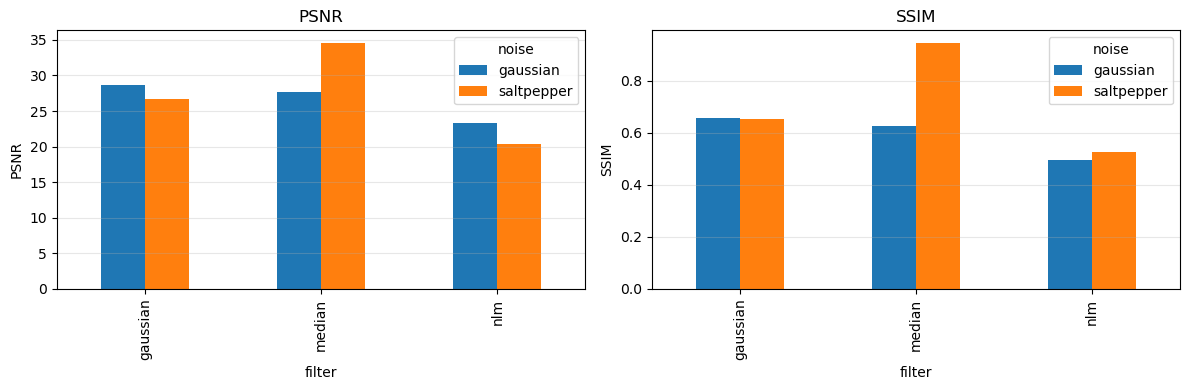

In [ ]:
# Plot bar charts
fig, axes = plt.subplots(1,2, figsize=(12,4), sharex=True) # Tạo biểu đồ thanh cho PSNR và SSIM
for i, metric in enumerate(['PSNR','SSIM']): # Lặp qua các chỉ số PSNR và SSIM
    pivot = agg.pivot(index='filter', columns='noise', values=metric) # Chuyển đổi dữ liệu để phù hợp với biểu đồ thanh
    pivot.plot(kind='bar', ax=axes[i]) # Vẽ biểu đồ thanh
    axes[i].set_title(metric) # Đặt tiêu đề cho biểu đồ
    axes[i].set_ylabel(metric) # Đặt nhãn trục y
    axes[i].grid(True, axis='y', alpha=0.3) # Thêm lưới cho trục y
plt.tight_layout() # Điều chỉnh bố cục biểu đồ
plt.show()


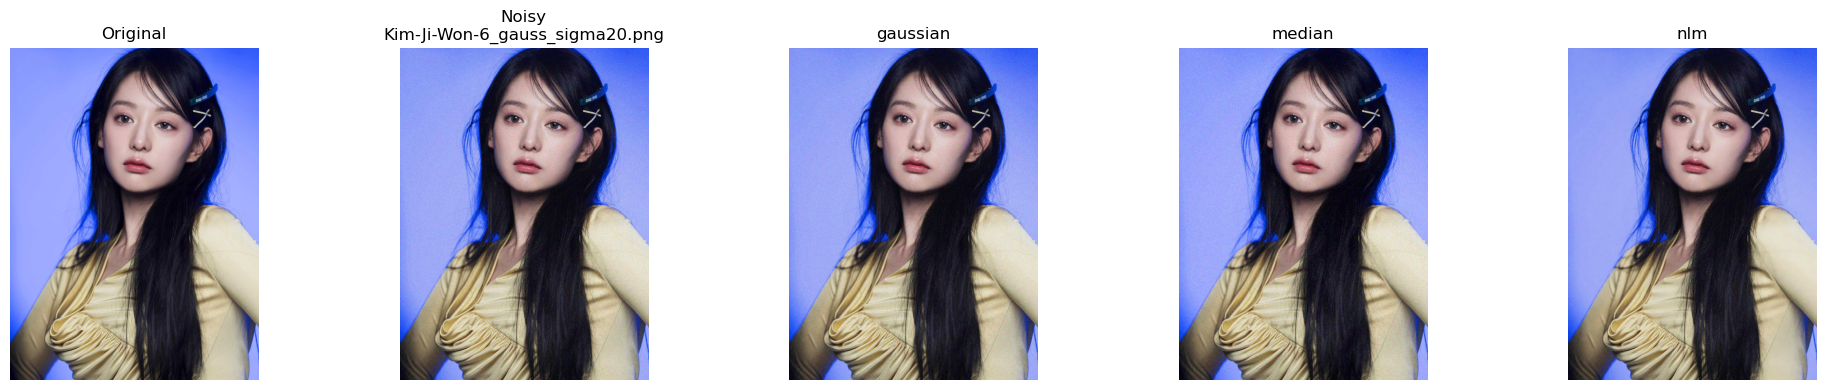

In [ ]:
#ìm và hiển thị một ảnh gốc, ảnh nhiễu, cùng các ảnh đã khử nhiễu (bằng nhiều phương pháp) của một mẫu bất kỳ
from pathlib import Path
import os, cv2, matplotlib.pyplot as plt

# Define directories
try:
    _root = project_root
except NameError:
    _root = Path(r'D:\Xu_ly_anh\image-denoise-project')

orig_dir = _root / 'data' / 'original'
noisy_dir = _root / 'data' / 'noisy'
den_dir  = _root / 'results' / 'denoised'

# pick one sample by image base
sample_image = df['image'].iloc[0] 

# find a noisy file for this image (prefer gaussian sigma20 if exists)
noisy_candidates = [f for f in os.listdir(str(noisy_dir)) if f.startswith(sample_image)]
noisy_file = None
for pref in ['gauss_sigma20', 'gauss_sigma10', 'sp_p3', 'sp_p1']:
    for f in noisy_candidates:
        if pref in f:
            noisy_file = f
            break
    if noisy_file:
        break
if noisy_file is None and noisy_candidates:
    noisy_file = noisy_candidates[0]

# load original (png/jpg/jpeg)
orig = cv2.imread(str(orig_dir / (sample_image + '.png')))
if orig is None:
    for ext in ['.jpg', '.jpeg']:
        p = orig_dir / (sample_image + ext)
        if p.exists():
            orig = cv2.imread(str(p))
            break
assert orig is not None, 'Original image not found for preview'

noisy = cv2.imread(str(noisy_dir / noisy_file))

# collect denoised variants for this noisy
variants = ['gaussian','median','bilateral','nlm']
den_imgs = {}
for v in variants:
    path = den_dir / (Path(noisy_file).stem + f'_{v}.png')
    if path.exists():
        den_imgs[v] = cv2.imread(str(path))

# show
cols = 2 + len(den_imgs) # original + noisy + denoised variants
fig, ax = plt.subplots(1, cols, figsize=(4*cols,4))
ax[0].imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)); ax[0].set_title('Original'); ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(noisy, cv2.COLOR_BGR2RGB)); ax[1].set_title(f'Noisy\n{noisy_file}'); ax[1].axis('off')
for i, (k, im) in enumerate(den_imgs.items(), start=2):
    ax[i].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); ax[i].set_title(k); ax[i].axis('off')
plt.tight_layout(); plt.show()

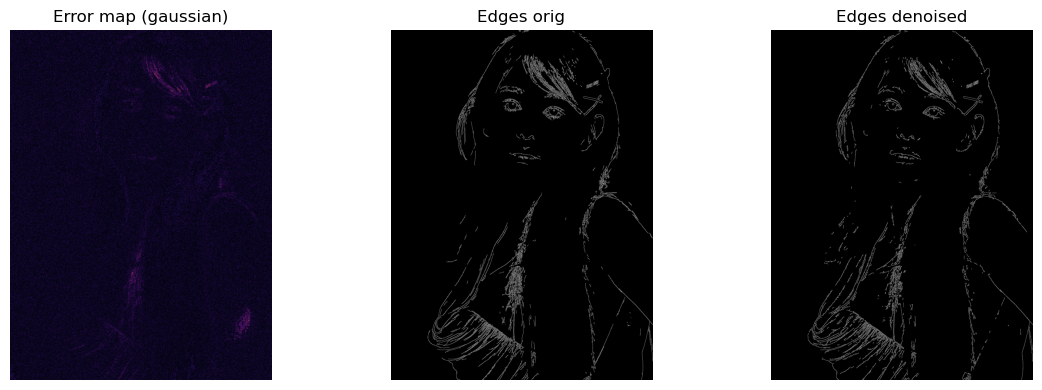

In [ ]:
# hiển thị bản đồ lỗi và các cạnh của ảnh gốc/ảnh đã khử nhiễu để so sánh trực quan chất lượng khử nhiễu

if noisy_file is not None and den_imgs: # Nếu tìm thấy hình ảnh đã khử nhiễu cho mẫu
    # pick first denoised
    key, den_im = list(den_imgs.items())[0] # Lấy hình ảnh đã khử nhiễu đầu tiên
    err = cv2.absdiff(cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY), cv2.cvtColor(den_im, cv2.COLOR_BGR2GRAY)) # Tính bản đồ lỗi giữa hình ảnh gốc và hình ảnh đã khử nhiễu
    edges_o = cv2.Canny(cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY), 100, 200) # Tìm cạnh trong hình ảnh gốc
    edges_d = cv2.Canny(cv2.cvtColor(den_im, cv2.COLOR_BGR2GRAY), 100, 200) # Tìm cạnh trong hình ảnh đã khử nhiễu
    fig, ax = plt.subplots(1,3, figsize=(12,4)) # Error map and edges for the same sample
    ax[0].imshow(err, cmap='inferno'); ax[0].set_title(f'Error map ({key})'); ax[0].axis('off') # Bản đồ lỗi
    ax[1].imshow(edges_o, cmap='gray'); ax[1].set_title('Edges orig'); ax[1].axis('off') # Tìm cạnh trong hình ảnh gốc
    ax[2].imshow(edges_d, cmap='gray'); ax[2].set_title('Edges denoised'); ax[2].axis('off') # Tìm cạnh trong hình ảnh đã khử nhiễu
    plt.tight_layout(); plt.show()
else:
    print('No denoised images found for the sample.')
